# AB InBev Beer Challenge

## Configuración y funciones a utilizar

In [1]:
import os
import polars as pl
import pandas as pd
pl.Config(tbl_rows=50)
import matplotlib.pyplot as plt
from functools import reduce
from collections import defaultdict, Counter
import numpy as np
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity
import pyarrow

In [2]:
def read_csv_with_lowercase_columns(file_path: str) -> pl.DataFrame:
    """
    Lee un archivo CSV y convierte todos los nombres de las columnas a minúsculas.

    Parameters:
    file_path (str): La ruta del archivo CSV.

    Returns:
    pl.DataFrame: Un DataFrame de polars con nombres de columnas en minúsculas.
    """
    # Leer el archivo CSV
    df = pl.read_csv(file_path,new_columns=["id"])
    
    # Transformar los nombres de las columnas a minúsculas
    df = df.rename({col: col.lower() for col in df.columns})
    
    return df


def count_unique_values(df: pl.DataFrame, columns: list) -> dict:
    """
    Cuenta los valores únicos de las columnas especificadas en un DataFrame.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    columns (list): Una lista de nombres de columnas para contar los valores únicos.

    Returns:
    dict: Un diccionario con los nombres de las columnas y la cantidad de valores únicos.
    """
    unique_counts = {col: df[col].n_unique() for col in columns}
    return unique_counts

def count_distinct_grouped_by(df: pl.DataFrame, y_column: str, x_columns: list, z_columns: list = None) -> pl.DataFrame:
    """
    Cuenta la cantidad de elementos distintos de una columna Y agrupado por los valores de una o más columnas X,
    ordena los resultados por una o más columnas Z de forma descendente, y calcula el porcentaje sobre el total
    de cada valor de la primera columna de agrupación.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    y_column (str): El nombre de la columna Y cuyos valores distintos se contarán.
    x_columns (list): Una lista de nombres de columnas X por las que se agrupará.
    z_columns (list, optional): Una lista de nombres de columnas Z por las que se ordenará de forma descendente.

    Returns:
    pl.DataFrame: Un nuevo DataFrame con los resultados de la cantidad de valores distintos de Y agrupados por X,
                  ordenados por las columnas Z y con el porcentaje calculado.
    """
    # Agrupar por las columnas X y contar los valores distintos de Y
    result = df.group_by(x_columns).agg([
        pl.col(y_column).n_unique().alias(f"{y_column}_distinct_count")
    ])
    
    # Si hay más de una columna en x_columns, calcular el total por cada valor de la primera columna de agrupación
    if len(x_columns) > 1:
        total_by_first_column = result.group_by(x_columns[0]).agg([
            pl.col(f"{y_column}_distinct_count").sum().alias("total_first_column")
        ])
        
        # Unir los totales al resultado original
        result = result.join(total_by_first_column, on=x_columns[0])
    else:
        # Si solo hay una columna de agrupación, calcular el total general
        total_general = result[f"{y_column}_distinct_count"].sum()
        result = result.with_columns([
            pl.lit(total_general).alias("total_first_column")
        ])
    
    # Calcular el porcentaje
    result = result.with_columns([
        (pl.col(f"{y_column}_distinct_count") / pl.col("total_first_column") * 100).alias(f"{y_column}_percentage")
    ])
    
    # Si se proporcionan columnas Z, ordenar por esas columnas en orden descendente
    if z_columns:
        result = result.sort(by=z_columns, descending = True)
    
    return result

def plot_histograms(df, columns):
    """
    Plots histograms for the specified columns in the DataFrame.

    Parameters:
    df (pl.DataFrame): The DataFrame containing the data.
    columns (list): A list of column names (strings) for which histograms should be plotted.
    """
    num_columns = len(columns)
    fig, axs = plt.subplots(1, num_columns, figsize=(5*num_columns, 5))
    
    if num_columns == 1:
        axs = [axs]  # Ensure axs is iterable if there's only one column

    for i, column in enumerate(columns):
        data = df.select(column).to_series()
        axs[i].hist(data, bins=10, color='skyblue', edgecolor='black')
        axs[i].set_title(f'Histogram of {column}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Create an item-user matrix using reduce
def update_item_user_matrix(acc, user_basket_pair):
    """
    Updates the item-user matrix with the given user-baskets pair.

    Parameters:
    acc (dict): The accumulator dictionary, where each key is an item and each value is another dictionary.
               The inner dictionary has users as keys and the count of the item in the user's baskets as values.
    user_basket_pair (tuple): A tuple containing the user ID and their baskets.

    Returns:
    dict: The updated accumulator dictionary.
    """
    user, baskets = user_basket_pair
    for basket in baskets:
        for item in basket:
            acc[item][user] += 1
    return acc

def item_to_vector(item, item_user_matrix, user_baskets):
    """
    Returns a vector representation of an item.

    Parameters:
    item (str): The item to convert to a vector.
    item_user_matrix (dict): A dictionary where each key is an item and each value is another dictionary.
                             The inner dictionary has users as keys and the count of the item in the user's baskets as values.
    user_baskets (dict): A dictionary where each key is a user and each value is a list of items in the user's baskets.

    Returns:
    list: A list of integers representing the count of the item in each user's baskets.
    """
    return [item_user_matrix[item][user] for user in user_baskets]

def replace_sd_with_null(df: pl.DataFrame, columns: list) -> pl.DataFrame:
    """
    Reemplaza todos los valores "S/D" por valores nulos en las columnas especificadas de un DataFrame de polars.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    columns (list): Una lista de nombres de columnas en las que se realizará la transformación.

    Returns:
    pl.DataFrame: Un nuevo DataFrame con los valores "S/D" reemplazados por nulos en las columnas especificadas.
    """
    # Reemplazar "S/D" con None en las columnas especificadas
    df = df.with_columns([
        pl.when(pl.col(col) == "S/D").then(None).otherwise(pl.col(col)).alias(col) for col in columns
    ])
    
    return df

def check_null_values(df: pl.DataFrame) -> pl.DataFrame:
    """
    Revisa valores nulos en un DataFrame de polars y retorna un DataFrame con la cantidad de nulos y el porcentaje de nulos por columna.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.

    Returns:
    pl.DataFrame: Un DataFrame con tres columnas: el nombre de la columna original, el conteo de valores nulos y el porcentaje de valores nulos en esa columna.
    """
    # Calcular la cantidad de nulos por columna
    null_counts = df.select([
        pl.col(col).is_null().sum().alias(col) for col in df.columns
    ])
    
    # Calcular el total de filas en el DataFrame
    total_rows = df.height
    
    # Transponer y renombrar columnas
    result = null_counts.transpose(include_header=True, header_name="column_name").rename({"column_name": "column", "column_0": "null_count"})
    
    # Calcular el porcentaje de nulos
    result = result.with_columns([
        (pl.col("null_count") / total_rows * 100).alias("null_percentage")
    ])
    
    return result

def count_distinct_in_bins(df: pl.DataFrame, volume_column: str, column: str, bin_size: int = 500) -> pl.DataFrame:
    """
    Cuenta los valores distintos de una columna dentro de rangos de tamaño específico en otra columna.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    volume_column (str): El nombre de la columna que contiene los volúmenes (por ejemplo, 'totalvolumen').
    pocr_column (str): El nombre de la columna cuyos valores distintos se contarán (por ejemplo, 'pocr').
    bin_size (int): El tamaño de cada bloque o rango (por defecto 500).

    Returns:
    pl.DataFrame: Un DataFrame con los rangos y la cantidad de valores distintos de pocr en cada rango.
    """
    # Crear una nueva columna que agrupa los valores en bloques de 'bin_size'
    df = df.with_columns([
        (pl.col(volume_column) // bin_size * bin_size).alias("volume_bin")
    ])
    
    # Agrupar por los bloques y contar los valores distintos de 'pocr'
    result = df.group_by("volume_bin").agg([
        pl.col(column).n_unique().alias(f"{column}_distinct_count")
    ])
     
     # Retornar el resultado por 'volume_bin' ordenado de menor a mayor
    return result.sort("volume_bin")

def plot_boxplots(df: pl.DataFrame, columns: list):
    """
    Genera un boxplot para cada columna en la lista de columnas ingresada.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    columns (list): Una lista de nombres de columnas para las cuales se generarán los boxplots.
    """
    # Convertir las columnas a pandas para la compatibilidad con matplotlib
    df_pandas = df.select(columns).to_pandas()
    
    # Generar un boxplot para cada columna
    for col in columns:
        plt.figure(figsize=(8, 6))
        plt.boxplot(df_pandas[col].dropna(), vert=False, patch_artist=True)
        plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.show()
        
def chi2_test(df: pl.DataFrame, col1: str, col2: str, confidence_level: float = 0.95):
    """
    Realiza la prueba de Chi-cuadrado para dos columnas categóricas y devuelve el p-valor y la conclusión.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    col1 (str): El nombre de la primera columna categórica.
    col2 (str): El nombre de la segunda columna categórica.
    confidence_level (float): El grado de confianza para la prueba (por defecto 0.95).

    Returns:
    tuple: Un tuple con el p-valor y la conclusión de la prueba.
    """
    # Convertir las columnas seleccionadas a pandas
    df_pandas = df.select([col1, col2]).to_pandas()
    
    # Crear una tabla de contingencia
    contingency_table = pd.crosstab(df_pandas[col1], df_pandas[col2])
    
    # Realizar la prueba Chi-cuadrado
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Calcular el alfa basado en el grado de confianza
    alpha = 1 - confidence_level
    
    # Conclusión basada en el p-valor y el grado de confianza
    if p_value < alpha:
        conclusion = "Rechazamos la hipótesis nula: Existe una asociación significativa entre las variables."
    else:
        conclusion = "No se puede rechazar la hipótesis nula: No existe evidencia suficiente para afirmar una asociación significativa entre las variables."
    
    return p_value, conclusion

def chi2_matrix(chi2_test_func, df: pl.DataFrame, categorical_columns: list, confidence_level: float ) -> np.ndarray:
    """
    Realiza la prueba de Chi-cuadrado entre todas las combinaciones de variables categóricas y devuelve una matriz de Verdadero/Falso.

    Parameters:
    chi2_test_func (function): La función que realiza la prueba de Chi-cuadrado.
    df (pl.DataFrame): El DataFrame de polars.
    categorical_columns (list): Una lista con los nombres de las variables categóricas.
    confidence_level (float): El grado de confianza para la prueba (por defecto 0.95).

    Returns:
    np.ndarray: Una matriz con valores Verdadero/Falso indicando si se rechaza la hipótesis nula para cada combinación.
    """
    n = len(categorical_columns)
    results_matrix = np.zeros((n, n), dtype=bool)

    # Realizar la prueba Chi-2 para todas las combinaciones de columnas categóricas
    for i in range(n):
        for j in range(i + 1, n):  # Comienza desde i+1 para evitar comparaciones duplicadas
            _, conclusion = chi2_test_func(df, categorical_columns[i], categorical_columns[j], confidence_level)
            results_matrix[i, j] = conclusion
            results_matrix[j, i] = conclusion  # La matriz es simétrica
            
    # Convertir la matriz en un DataFrame de pandas y asignar nombres a filas y columnas
    results_df = pd.DataFrame(results_matrix, index=categorical_columns, columns=categorical_columns)

    return results_df


## Extracción de los datos

In [3]:
# Read the csv files of the atributes
file_path_atributes = "../data/raw/atributos.csv"
atributes = read_csv_with_lowercase_columns(file_path_atributes)
categorical = ["bussinesssegment","concentracion","nse","segmentounico","canal"]
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
# Read the csv files of the transactions
file_path_transactions = "../data/raw/transacciones.csv"
transactions = read_csv_with_lowercase_columns(file_path_transactions)
# Display the first rows of the DataFrame of the transactions
print(transactions.head())

shape: (5, 6)
┌─────┬────────────┬────────┬──────────────┬───────────────┬──────────────────┐
│ id  ┆ account_id ┆ sku_id ┆ invoice_date ┆ order_id      ┆ items_phys_cases │
│ --- ┆ ---        ┆ ---    ┆ ---          ┆ ---           ┆ ---              │
│ i64 ┆ i64        ┆ i64    ┆ i64          ┆ str           ┆ f64              │
╞═════╪════════════╪════════╪══════════════╪═══════════════╪══════════════════╡
│ 0   ┆ 430606     ┆ 7038   ┆ 20220729     ┆ 512-3880249-0 ┆ 100.0            │
│ 1   ┆ 323267     ┆ 14933  ┆ 20220729     ┆ 512-3882307-0 ┆ 1.0              │
│ 2   ┆ 357825     ┆ 21971  ┆ 20220723     ┆ 512-3852880-0 ┆ 8.0              │
│ 3   ┆ 444926     ┆ 7038   ┆ 20220805     ┆ 512-3913163-0 ┆ 20.0             │
│ 4   ┆ 450771     ┆ 7030   ┆ 20220816     ┆ 512-3957000-0 ┆ 5.0              │
└─────┴────────────┴────────┴──────────────┴───────────────┴──────────────────┘


In [4]:
# Display the first rows of the DataFrame of the atribues
atributes.head()

id,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,nse,segmentounico,canal
i64,i64,str,f64,f64,i64,str,str,str,str
10,175519,"""HighUsage""",5.18752,4.1,16,"""Medio""","""Bajo""","""4.Activos""","""Kioscos/Maxikioscos"""
13,28533,"""HighUsage""",4.76866,3.9211,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
19,32182,"""PowerUsage""",5.9793,6.75,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
20,327976,"""MinimalUsage""",6.02852,3.5833,14,"""Alto""","""Medio""","""4.Activos""","""COMIDA"""
24,354640,"""PowerUsage""",7.525,3.2,18,"""Bajo""","""S/D""","""4.Activos""","""Tradicional"""


## Preprocesamiento necesario para EDA

En las los atributos:

* Calidad de los datos:
    * Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

En las transacciones:

* Calidad de los datos:
    *Revisar valores nulos
    * Revisar valores fuera de rango
    * Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.


### Datos de atributos de los clientes

#### Calidad de los datos:
* Revisar valores nulos : se borra nse por tener un 23%
* Revisar valores fuera de rango
* Cuantificar outliers

In [5]:
# Reemplazar "S/D" por nulos en las columnas "nse" y "concentración"
atributes = replace_sd_with_null(atributes, ["nse", "concentracion"])
# Revisar valores nulos en el DataFrame
null_values_df = check_null_values(atributes)
# Mostrar el resultado
print(null_values_df)

shape: (10, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│ id                          ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ nse                         ┆ 1023       ┆ 23.25           │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴─────────

In [6]:
categorical = ["bussinesssegment","concentracion","segmentounico","canal"]
# Eliminar la columna "nse" del DataFrame
atributes = atributes.drop("nse")
null_values_df = check_null_values(atributes)
print(null_values_df)

shape: (9, 3)
┌─────────────────────────────┬────────────┬─────────────────┐
│ column                      ┆ null_count ┆ null_percentage │
│ ---                         ┆ ---        ┆ ---             │
│ str                         ┆ u32        ┆ f64             │
╞═════════════════════════════╪════════════╪═════════════════╡
│ id                          ┆ 0          ┆ 0.0             │
│ poc                         ┆ 0          ┆ 0.0             │
│ bussinesssegment            ┆ 0          ┆ 0.0             │
│ totalvolumen                ┆ 0          ┆ 0.0             │
│ skudistintospromediosxorden ┆ 0          ┆ 0.0             │
│ skudistintostotales         ┆ 0          ┆ 0.0             │
│ concentracion               ┆ 326        ┆ 7.409091        │
│ segmentounico               ┆ 75         ┆ 1.704545        │
│ canal                       ┆ 14         ┆ 0.318182        │
└─────────────────────────────┴────────────┴─────────────────┘


In [7]:
# Crear una máscara booleana que verifica si hay algún valor nulo en cada fila
null_mask = atributes.select([
    pl.col(col).is_null() for col in atributes.columns
]).with_columns([
    pl.any_horizontal("*").alias("has_null")
]).select("has_null")

# Filtrar las filas que tienen algún valor nulo
df_with_nulls = atributes.with_columns(null_mask).filter(pl.col("has_null"))

# Mostrar las primeras filas del DataFrame con nulos
df_with_nulls[numerical].describe()

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",389.0,389.0,389.0
"""null_count""",0.0,0.0,0.0
"""mean""",28.747058,6.941624,22.719794
"""std""",130.752357,4.120482,17.900963
"""min""",0.02508,0.75,3.0
"""25%""",1.57647,4.0,10.0
"""50%""",4.19166,6.0,18.0
"""75%""",10.29528,8.6,29.0
"""max""",1623.86264,33.0,112.0


shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4400.0       ┆ 4400.0                      ┆ 4400.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 22.272537    ┆ 5.911031                    ┆ 27.832727           │
│ std        ┆ 106.642437   ┆ 3.227491                    ┆ 21.640289           │
│ min        ┆ 0.02124      ┆ 0.7027                      ┆ 1.0                 │
│ 25%        ┆ 2.12124      ┆ 3.6667                      ┆ 12.0                │
│ 50%        ┆ 5.6011       ┆ 5.1429                      ┆ 22.0                │
│ 

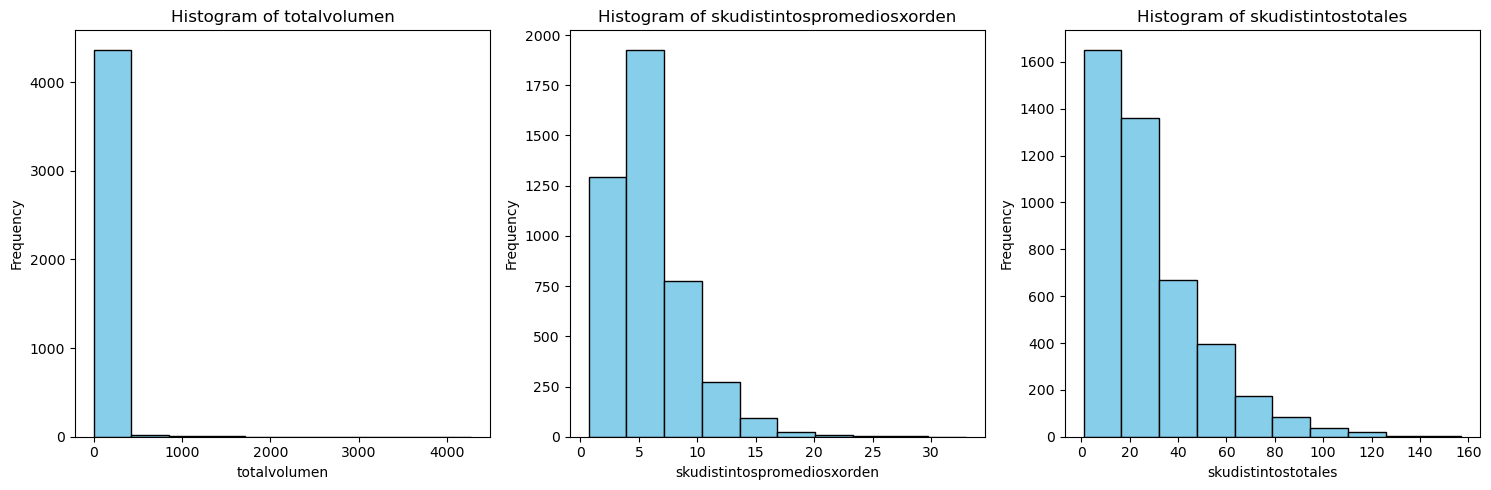

shape: (16, 2)
┌────────────┬────────────────────┐
│ volume_bin ┆ poc_distinct_count │
│ ---        ┆ ---                │
│ f64        ┆ u32                │
╞════════════╪════════════════════╡
│ 0.0        ┆ 4261               │
│ 100.0      ┆ 61                 │
│ 200.0      ┆ 28                 │
│ 300.0      ┆ 15                 │
│ 400.0      ┆ 7                  │
│ 500.0      ┆ 4                  │
│ 600.0      ┆ 5                  │
│ 700.0      ┆ 3                  │
│ 800.0      ┆ 3                  │
│ 900.0      ┆ 2                  │
│ 1000.0     ┆ 3                  │
│ 1100.0     ┆ 2                  │
│ 1200.0     ┆ 1                  │
│ 1300.0     ┆ 1                  │
│ 1600.0     ┆ 3                  │
│ 4200.0     ┆ 1                  │
└────────────┴────────────────────┘


In [8]:
# measures of central tendency for numerical data
print(atributes[numerical].describe())
plot_histograms(atributes, numerical)
# Contar los valores distintos de 'pocr' en bloques de 500 en la columna 'totalvolumen'
result = count_distinct_in_bins(atributes, volume_column="totalvolumen", column="poc", bin_size=100)
# Mostrar el resultado
print(result)

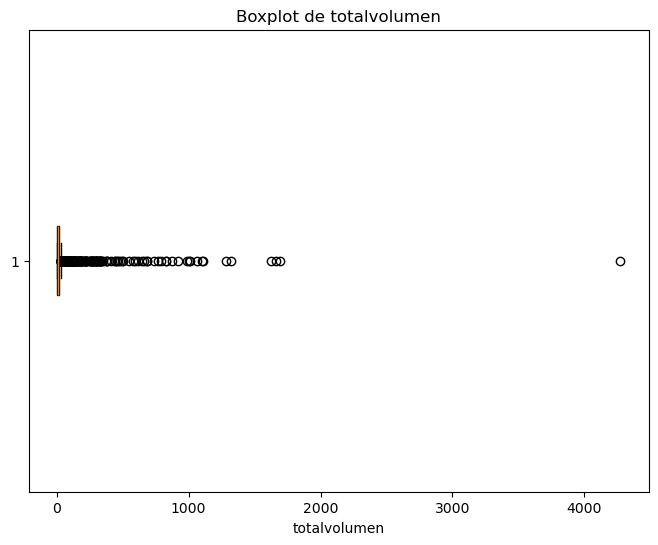

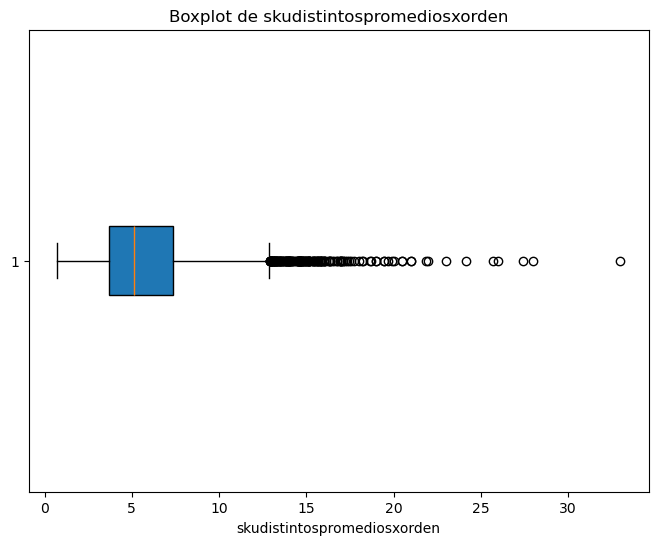

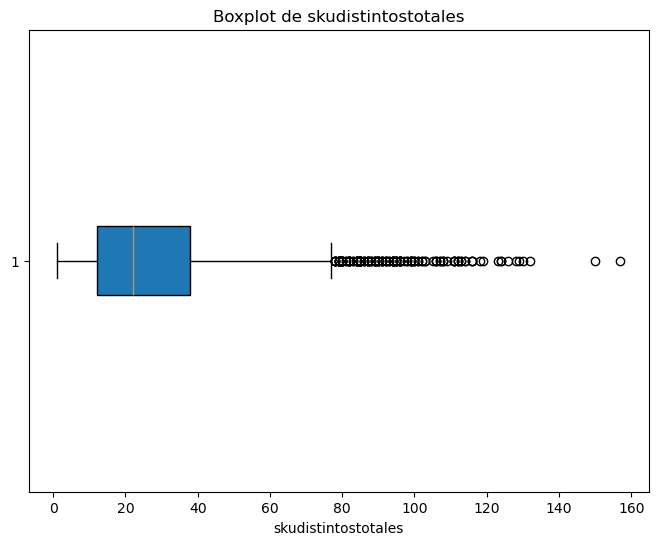

In [9]:
plot_boxplots(atributes, numerical)

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 4261.0       ┆ 4261.0                      ┆ 4261.0              │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 10.555502    ┆ 5.949519                    ┆ 27.481342           │
│ std        ┆ 14.581388    ┆ 3.193991                    ┆ 21.533846           │
│ min        ┆ 0.02124      ┆ 0.75                        ┆ 1.0                 │
│ 25%        ┆ 2.03756      ┆ 3.7143                      ┆ 12.0                │
│ 50%        ┆ 5.31534      ┆ 5.2                         ┆ 21.0                │
│ 

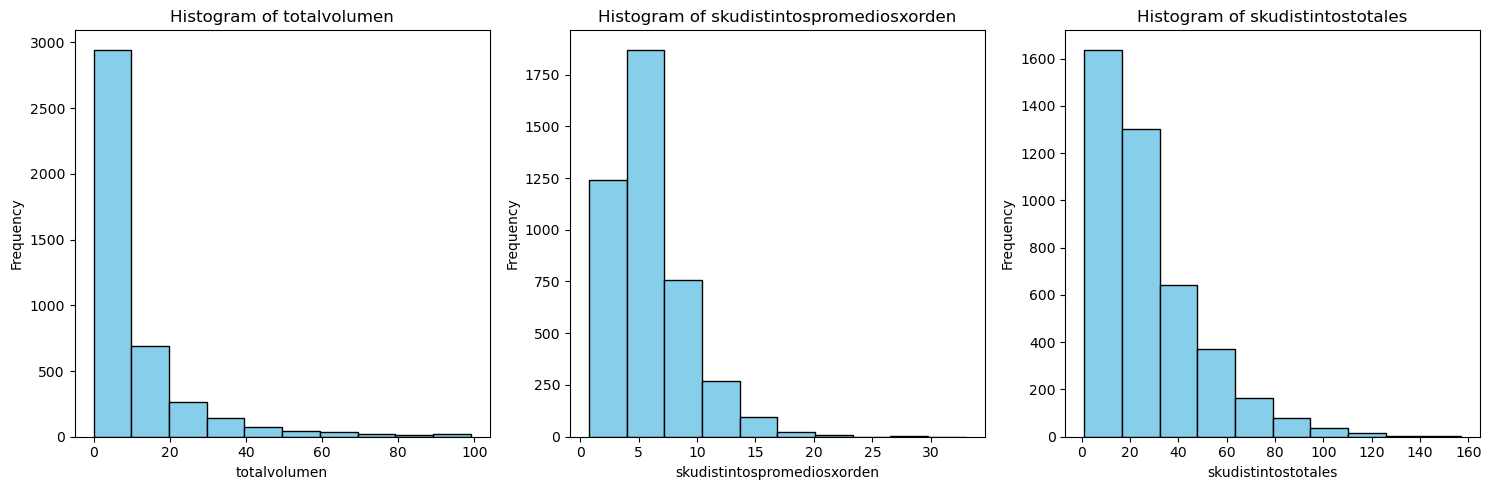

In [10]:
# Filtrar los resultados para mostrar solo aquellos clientes con volumen de compra menores o iguales a 100 (97% de los datos)
outliers = atributes.filter(pl.col("totalvolumen") > 100)
filtered_result = atributes.filter(pl.col("totalvolumen") <= 100)
print(filtered_result[numerical].describe())
plot_histograms(filtered_result, numerical)

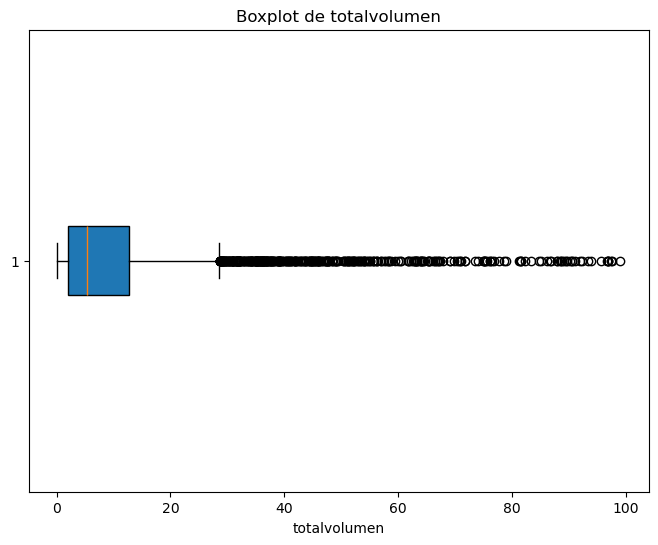

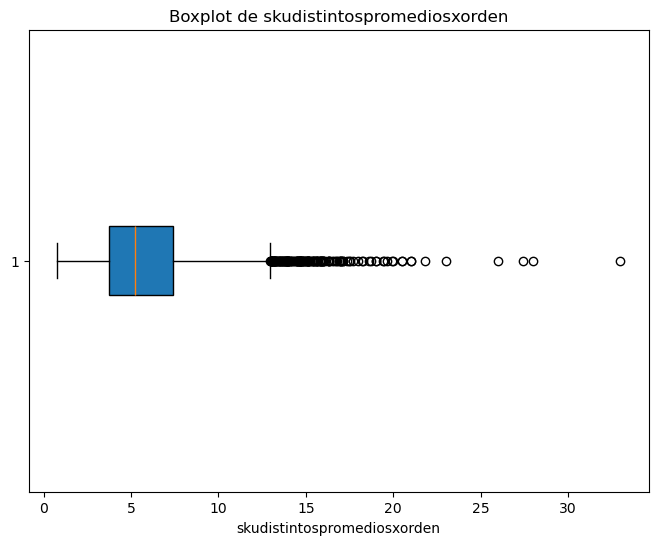

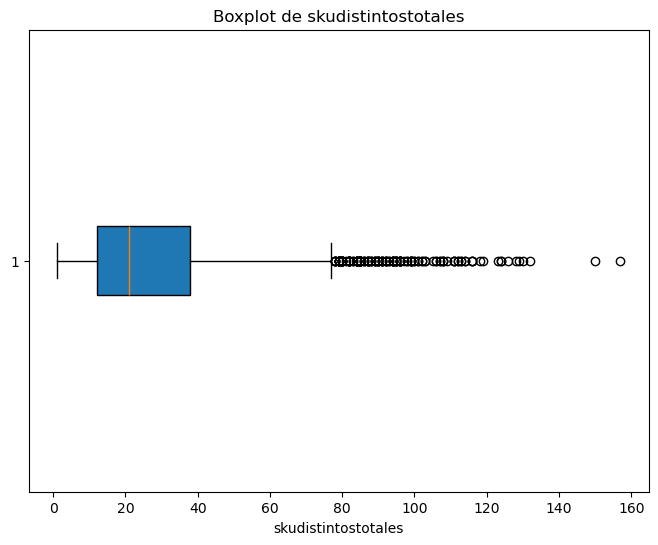

In [11]:
plot_boxplots(filtered_result, numerical)

shape: (9, 4)
┌────────────┬──────────────┬─────────────────────────────┬─────────────────────┐
│ statistic  ┆ totalvolumen ┆ skudistintospromediosxorden ┆ skudistintostotales │
│ ---        ┆ ---          ┆ ---                         ┆ ---                 │
│ str        ┆ f64          ┆ f64                         ┆ f64                 │
╞════════════╪══════════════╪═════════════════════════════╪═════════════════════╡
│ count      ┆ 139.0        ┆ 139.0                       ┆ 139.0               │
│ null_count ┆ 0.0          ┆ 0.0                         ┆ 0.0                 │
│ mean       ┆ 381.454472   ┆ 4.731182                    ┆ 38.604317           │
│ std        ┆ 470.928405   ┆ 3.960411                    ┆ 22.200868           │
│ min        ┆ 100.71814    ┆ 0.7027                      ┆ 3.0                 │
│ 25%        ┆ 135.84414    ┆ 2.4831                      ┆ 24.0                │
│ 50%        ┆ 231.26044    ┆ 3.54                        ┆ 32.0                │
│ 

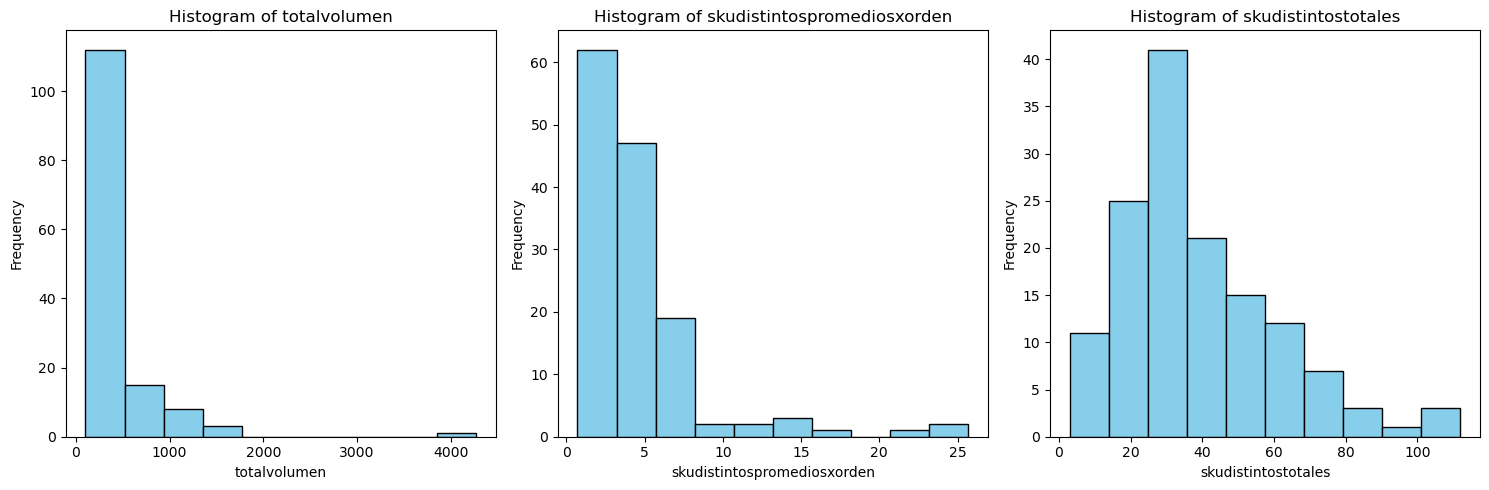

In [12]:
print(outliers[numerical].describe())
plot_histograms(outliers, numerical)

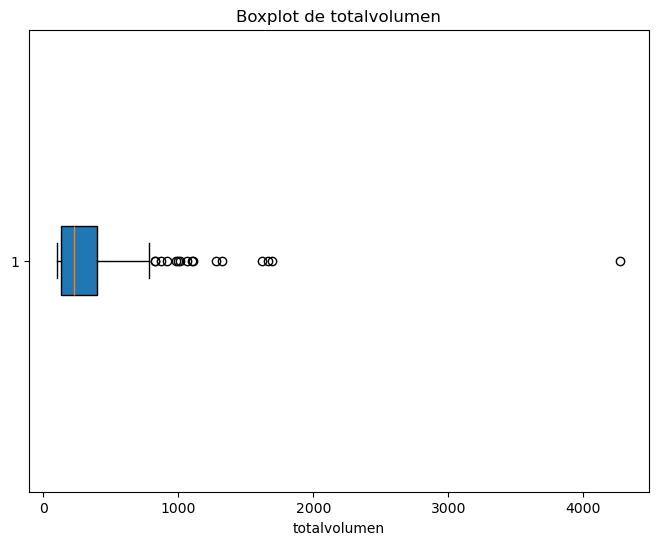

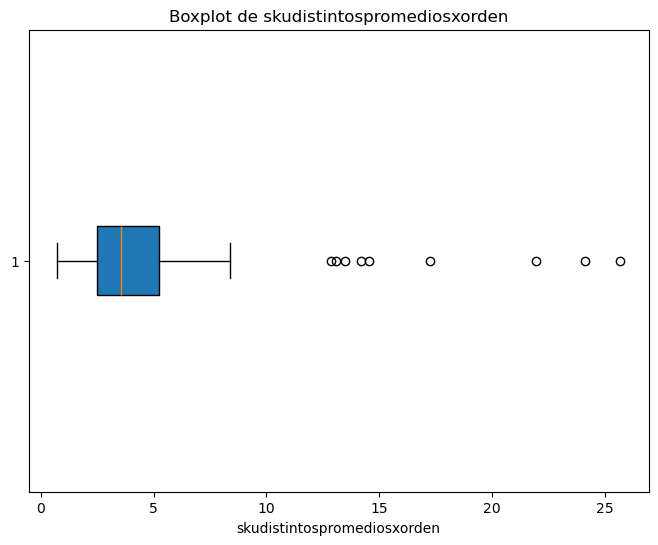

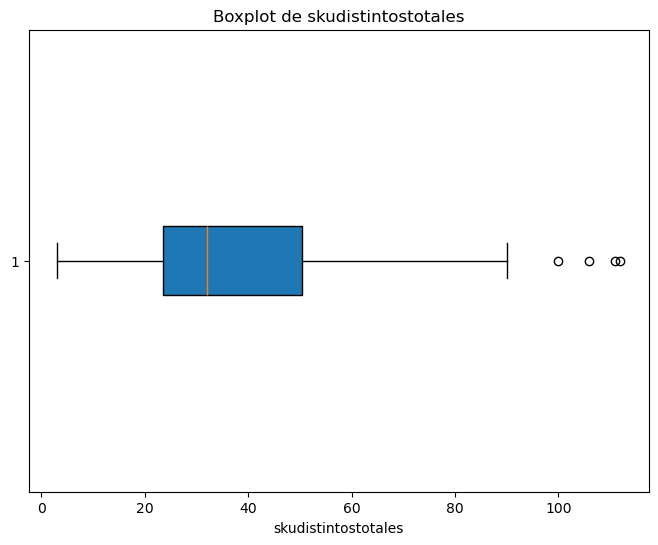

In [13]:
plot_boxplots(outliers, numerical)


### Datos de transacciones de los clientes

#### Calidad de los datos:
* Revisar valores nulos
* Revisar valores fuera de rango
* Cuantificar outliers

Transformaciones y/o agregaciones:

* Convertir invoice_date a un formato de fecha: Aunque actualmente es un entero,convertiremos la variable invoice_date a un tipo de dato de fecha para realizar análisis temporales.

* Crear dataset aparte con agrupación por cliente: Dado que estamos interesados en el comportamiento de compra de los clientes, vamos a agrupar los datos por account_id para analizar patrones de compra individuales.

* Crear dataset aparte con agrupación por item: Dado que también estamos interesados en el comportamiento de compra sobre los items, vamos a agrupar los datos por sku_id para analizar patrones de compra que se dan en general para los items.

## EDA --> Preguntas a contestar

**Sobre las clientes**
* ¿A cúantos clientes se les debe hacer recomendación?
* ¿Cuánto compran los clientes?
* Si los categorizo por:
    * Segmento de negocio
    * Concentración
    * NSE
    * Segmento único
    * Canal
¿Hay diferencias significativas?
¿Hay relación entre los clientes de las distintas categorías?
  
* ¿Con qué frecuencia los clientes realizan compras?
* ¿Cómo varía la frecuencia de compra a lo largo del tiempo?
* ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?
* ¿Cuál es el tiempo entre compras consecutivas de los cliente?
* ¿Cuál es la frecuencia de compra por cliente?
* ¿Existen clientes con comportamiento de compra repetitivo? ¿Quienes?
* ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
* ¿Cómo evolucionan las ventas en diferentes cohortes?


**Sobre las canastas**
* ¿Cúanto es el gasto por canasta?
* ¿Cuantas canastas compran los clientes?
* ¿Cuántos items compran por canasta?



**Sobre los items**
* ¿Cuál es la cantidad total de items disponibles para recomendación?
* ¿Cuál es la cantidad de items por canasta?
* ¿Cuál es la cantidad de items por cliente disponible para recomendación?

**Anomalias**

* ¿Existen anomalías o irregularidades en la distribución de fechas de compra?
* ¿Cómo afectan estas anomalías al negocio?

### Análisis sobre los clientes 

#### ¿A cúantos clientes se les debe hacer recomendación?

R: 4400 clientes

* ¿Cuánto compran los clientes?

R: Compran, en promedio, 5.9 productos distintos por orden en un periodo aproximado de 3 meses, el 50% compra 22 o más productos y 5.6 o más litros de cerveza. Es importante recalcar que el 75% compra hasta 14 litros, pero hay clientes que llegan a comprar 4274 litros en este periodo

In [14]:
# measures of central tendency for numerical data
atributes[numerical].describe()

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


#### ¿Hay diferencias significativas en la categoría? Si los categorizo por:
* Segmento de negocio : aunque es homogenea, es importante notar que solo un 21% de los clientes tiene un nivel de uso bajo o nulo de la aplicación (potencialmente descartable para el MVP)
* Concentración : No es homogenea y la concentración de otros negocios de otra índole a 150mts2 es de un 90% su agrupamos los niveles alto y medio 
* NSE : No es homogenea y es importante notar que un 23% está sin datos
* Segmento único: No es homogenea y los clientes con capacidad media de compra son el 61%, mientras que el 20% es de baja y el 17% es de alta, el resto no tiene datos
* Canal : el 88% de los clientes pertenece al canal tradidicional, Kioscos o Maxikioscos  o Comida

¿Estas categorías son independientes entre si?
No, las categorías no son independientes entre si

Adicionalmente, vemos que no hay diferencias significativas en las relaciones encontradas cuando se observa solo los datos que tienen volúmenes altos

In [15]:
results = count_unique_values(atributes, categorical)
results

{'bussinesssegment': 4, 'concentracion': 4, 'segmentounico': 6, 'canal': 12}

In [16]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"])
result

bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""PowerUsage""",1213,4400,27.568182
"""HighUsage""",1213,4400,27.568182
"""MediumUsage""",1050,4400,23.863636
"""MinimalUsage""",924,4400,21.0


In [17]:
count_distinct_grouped_by(outliers, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"])

bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""HighUsage""",45,139,32.374101
"""PowerUsage""",39,139,28.057554
"""MediumUsage""",38,139,27.338129
"""MinimalUsage""",17,139,12.230216


In [18]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"])
result

concentracion,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Alto""",2125,4400,48.295455
"""Medio""",1826,4400,41.5
null,326,4400,7.409091
"""Bajo""",123,4400,2.795455


In [19]:
count_distinct_grouped_by(outliers, y_column="poc", x_columns=["concentracion"],z_columns=["poc_percentage"])

concentracion,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Medio""",66,139,47.482014
"""Alto""",52,139,37.410072
null,17,139,12.230216
"""Bajo""",4,139,2.877698


In [20]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])
result

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""4.Activos""",1894,4400,43.045455
"""1.Inactivos""",884,4400,20.090909
"""2.Masivos""",790,4400,17.954545
"""5.Select""",631,4400,14.340909
"""3.Potenciales""",126,4400,2.863636
null,75,4400,1.704545


In [21]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(outliers, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])
result

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""5.Select""",71,139,51.079137
"""4.Activos""",45,139,32.374101
"""2.Masivos""",12,139,8.633094
null,6,139,4.316547
"""3.Potenciales""",5,139,3.597122


In [22]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])
result

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",2657,4400,60.386364
"""Kioscos/Maxikioscos""",820,4400,18.636364
"""COMIDA""",412,4400,9.363636
"""Autoservicio""",186,4400,4.227273
"""BEBIDA""",100,4400,2.272727
"""ENTRETENIMIENTO""",79,4400,1.795455
"""Mayorista""",52,4400,1.181818
"""Instituciones""",43,4400,0.977273
"""KA Minoristas""",18,4400,0.409091


In [23]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(outliers, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])
result

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",58,139,41.726619
"""Mayorista""",33,139,23.741007
"""Autoservicio""",13,139,9.352518
"""Kioscos/Maxikioscos""",12,139,8.633094
"""COMIDA""",10,139,7.194245
"""BEBIDA""",6,139,4.316547
"""KA Minoristas""",3,139,2.158273
"""Instituciones""",2,139,1.438849
"""ENTRETENIMIENTO""",1,139,0.719424


In [24]:
# Obtener la matriz de resultados
chi2_results_matrix = chi2_matrix(chi2_test, atributes, categorical, confidence_level=0.99)
chi2_results_matrix

,bussinesssegment,concentracion,segmentounico,canal
bussinesssegment,False,True,True,True
concentracion,True,False,True,True
segmentounico,True,True,False,True
canal,True,True,True,False


#### ¿Con qué frecuencia los clientes realizan compras?

#### ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?

#### ¿Cuál es la cantidad de clientes que compran por item disponible para recomendación?
* ¿Cuál es el tiempo entre compras consecutivas de los cliente?
* ¿Cuál es la frecuencia de compra por cliente?
* ¿Existen clientes con comportamiento de compra repetitivo? ¿Quienes?
* ¿Cómo se comportan las diferentes cohortes de clientes a lo largo del tiempo?
* ¿Cómo evolucionan las ventas en diferentes cohortes?

In [25]:
# Example data: list of baskets for each user
user_baskets = {
    'user1': [['item1', 'item2'], ['item2', 'item3'], ['item1', 'item3', 'item4']],
    'user2': [['item1'], ['item2', 'item4'], ['item2', 'item3', 'item5']],
    'user3': [['item1', 'item3'], ['item3', 'item4'], ['item2', 'item5']]
}

item_user_matrix = reduce(
    update_item_user_matrix,
    user_baskets.items(),
    defaultdict(lambda: defaultdict(int))
)

items = list(item_user_matrix.keys())
item_user_vectors = np.array(list(map(item_to_vector, items)))

TypeError: item_to_vector() missing 2 required positional arguments: 'item_user_matrix' and 'user_baskets'